# Optimization WFA - Logistic Regression

## Logistic Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [6]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [8]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [9]:
XAUUSD = load_data()

In [66]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [67]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


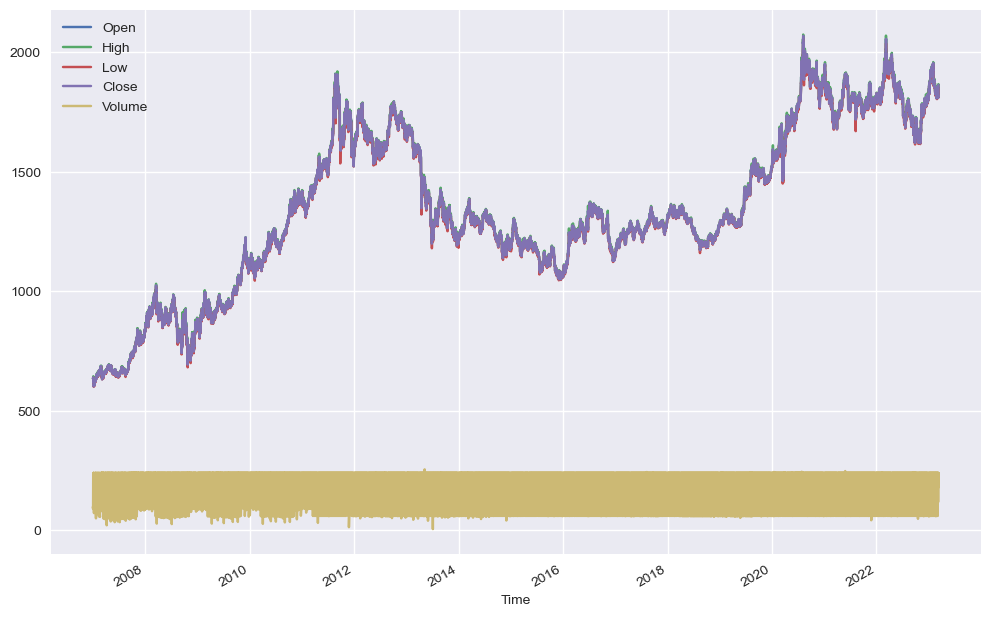

In [68]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [10]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [11]:
mainFolder = 'Machine_Learning'
strategy = Logistic_Regression
strategyName = 'Logistic_Regressionon'
account_size = 1000
folder_ML_Strategy = 'Logistic Regression'
subFolder = 'Optimization'

In [12]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size , account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data["returns_signal"] = data["returns"].shift(-1)
        data["direction"] = np.sign(data.returns_signal)
        data.dropna(inplace=True)
        cols = []
        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size + 1:i + 1]

            lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr" )
            lm.fit(rolling_window_data[cols], rolling_window_data['direction'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()


    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy, cash = account_size  , margin= 1/100)
        result = backtest.run()
        return result

    

    def Run(self) :
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [72]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [73]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [74]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [75]:
test = ml.Run()

In [76]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   94.976172
Equity Final [$]                     6225.555
Equity Peak [$]                      6300.681
Return [%]                           522.5555
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    9.582308
Volatility (Ann.) [%]                9.051071
Sharpe Ratio                         1.058693
Sortino Ratio                        1.720694
Calmar Ratio                         0.633092
Max. Drawdown [%]                  -15.135717
Avg. Drawdown [%]                   -1.288736
Max. Drawdown Duration      567 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades                                 1650
Win Rate [%]                        56.484848
Best Trade [%]                      13.496237
Worst Trade [%]                    -13.859275
Avg. Trade [%]                    

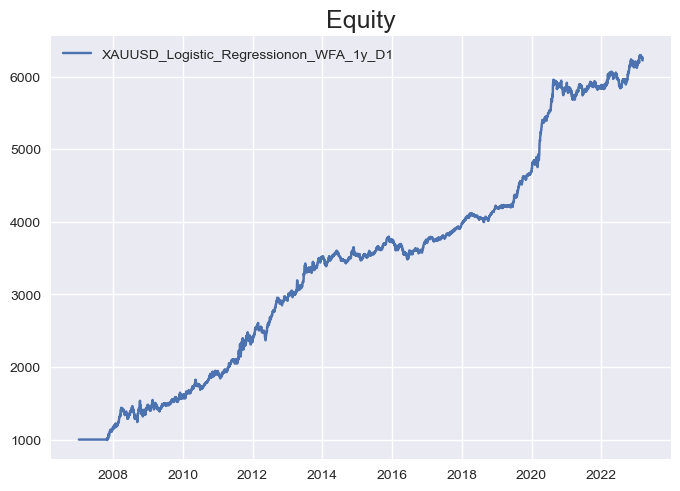

In [77]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [78]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [79]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [80]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [81]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [82]:
test = ml.Run()

In [83]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                     89.9722
Equity Final [$]                     4896.611
Equity Peak [$]                      4965.768
Return [%]                           389.6611
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    8.273501
Volatility (Ann.) [%]                9.431712
Sharpe Ratio                           0.8772
Sortino Ratio                        1.441034
Calmar Ratio                         0.772888
Max. Drawdown [%]                   -10.70465
Avg. Drawdown [%]                   -1.582003
Max. Drawdown Duration     1232 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                 1311
Win Rate [%]                        54.462243
Best Trade [%]                      15.219944
Worst Trade [%]                    -12.434624
Avg. Trade [%]                    

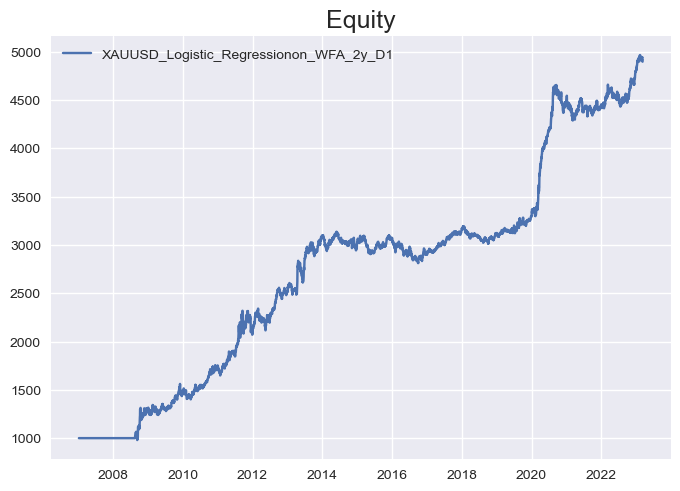

In [84]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [85]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [86]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [87]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [88]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [89]:
test = ml.Run()

In [90]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   84.968229
Equity Final [$]                     3715.526
Equity Peak [$]                      3766.798
Return [%]                           271.5526
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    6.788295
Volatility (Ann.) [%]               10.588248
Sharpe Ratio                         0.641116
Sortino Ratio                        1.005776
Calmar Ratio                         0.317524
Max. Drawdown [%]                  -21.378828
Avg. Drawdown [%]                   -2.179061
Max. Drawdown Duration     1559 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                  987
Win Rate [%]                        52.786221
Best Trade [%]                       27.89603
Worst Trade [%]                     -7.898505
Avg. Trade [%]                    

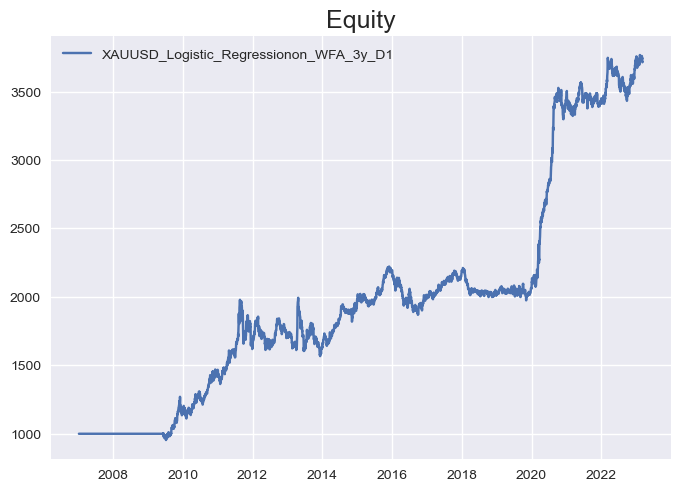

In [91]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [92]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [93]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [94]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [95]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [96]:
test = ml.Run()

In [97]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   79.964257
Equity Final [$]                      2666.88
Equity Peak [$]                      2964.209
Return [%]                            166.688
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    5.030901
Volatility (Ann.) [%]               12.480832
Sharpe Ratio                          0.40309
Sortino Ratio                        0.591871
Calmar Ratio                          0.10855
Max. Drawdown [%]                  -46.346506
Avg. Drawdown [%]                   -2.937092
Max. Drawdown Duration     3108 days 00:00:00
Avg. Drawdown Duration       77 days 00:00:00
# Trades                                  855
Win Rate [%]                        53.333333
Best Trade [%]                      64.397924
Worst Trade [%]                       -9.7927
Avg. Trade [%]                    

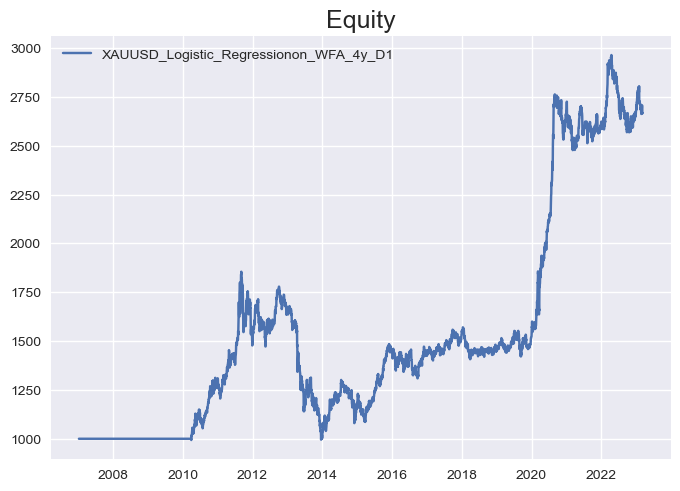

In [98]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [99]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [100]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [101]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [102]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [103]:
test = ml.Run()

In [104]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   74.960286
Equity Final [$]                     1469.076
Equity Peak [$]                      1682.037
Return [%]                            46.9076
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    1.943337
Volatility (Ann.) [%]               16.646132
Sharpe Ratio                         0.116744
Sortino Ratio                        0.165738
Calmar Ratio                         0.039244
Max. Drawdown [%]                  -49.519553
Avg. Drawdown [%]                   -6.755972
Max. Drawdown Duration     3272 days 00:00:00
Avg. Drawdown Duration      220 days 00:00:00
# Trades                                  751
Win Rate [%]                        52.596538
Best Trade [%]                      18.997069
Worst Trade [%]                    -13.480854
Avg. Trade [%]                    

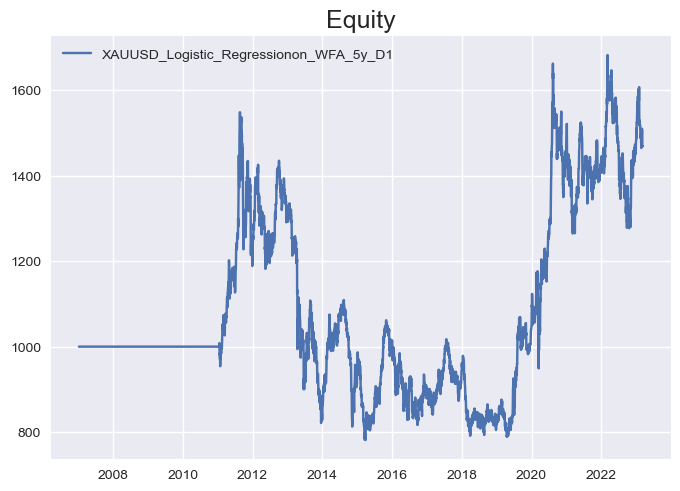

In [105]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [106]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [107]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [108]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [109]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [110]:
test = ml.Run()

In [111]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   36.973789
Equity Final [$]                        7.509
Equity Peak [$]                      1002.374
Return [%]                           -99.2491
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                  -21.712083
Volatility (Ann.) [%]                59.74254
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.250878
Avg. Drawdown [%]                  -42.853572
Max. Drawdown Duration     3808 days 00:00:00
Avg. Drawdown Duration     1380 days 00:00:00
# Trades                                  436
Win Rate [%]                        47.477064
Best Trade [%]                       5.906636
Worst Trade [%]                     -9.698993
Avg. Trade [%]                    

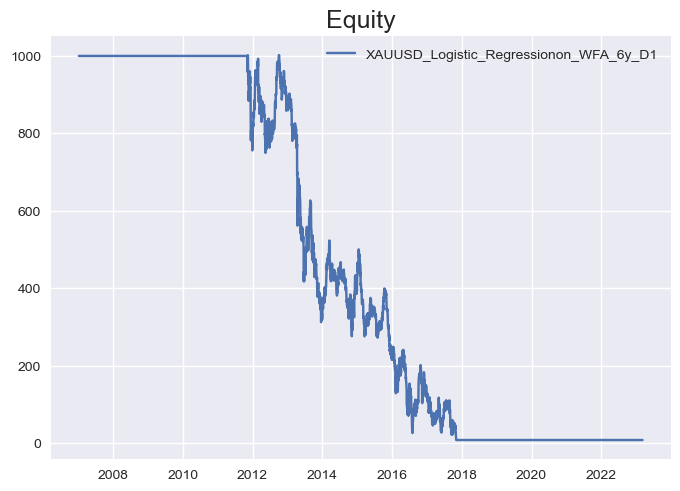

In [112]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [113]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [114]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [115]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [116]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [117]:
test = ml.Run()

In [118]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   35.007943
Equity Final [$]                       11.145
Equity Peak [$]                      1137.327
Return [%]                           -98.8855
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -20.14972
Volatility (Ann.) [%]               31.815171
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.020071
Avg. Drawdown [%]                  -14.745917
Max. Drawdown Duration     3808 days 00:00:00
Avg. Drawdown Duration      548 days 00:00:00
# Trades                                  424
Win Rate [%]                        45.518868
Best Trade [%]                       4.917871
Worst Trade [%]                    -11.478504
Avg. Trade [%]                    

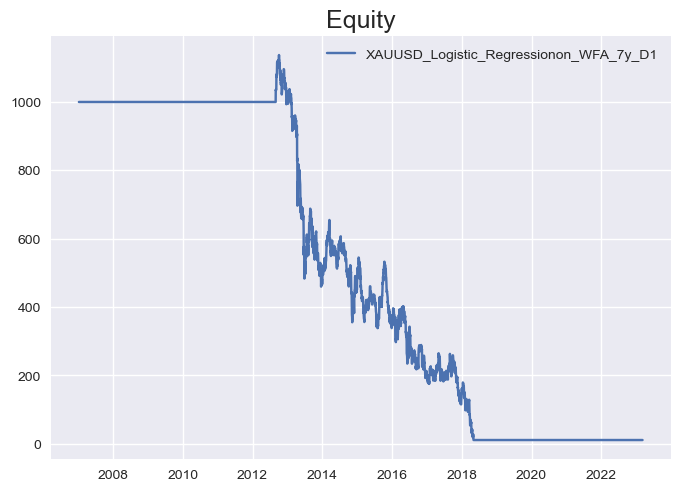

In [119]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [120]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [121]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [122]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [123]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [124]:
test = ml.Run()

In [125]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   59.948372
Equity Final [$]                      925.448
Equity Peak [$]                      1293.705
Return [%]                            -7.4552
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -0.386944
Volatility (Ann.) [%]               17.420539
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -47.561347
Avg. Drawdown [%]                  -12.204871
Max. Drawdown Duration     2523 days 00:00:00
Avg. Drawdown Duration      393 days 00:00:00
# Trades                                  651
Win Rate [%]                        47.004608
Best Trade [%]                      11.066558
Worst Trade [%]                    -12.444285
Avg. Trade [%]                    

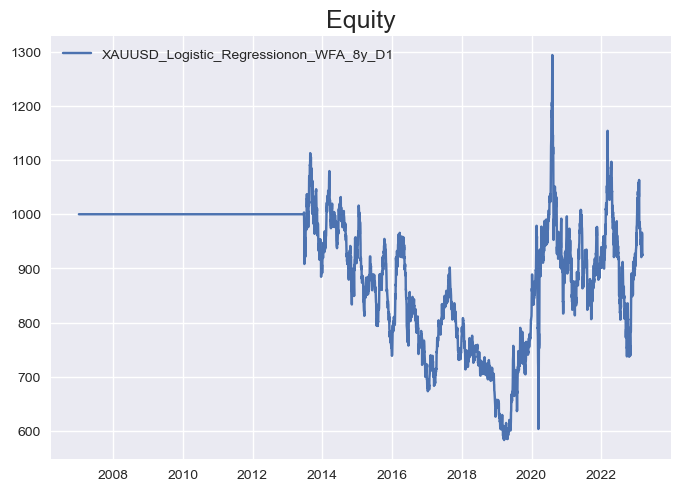

In [126]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [127]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [128]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [129]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H4'

### Window size 1 year

In [130]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [131]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [132]:
test = ml.Run()

In [133]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   94.173823
Equity Final [$]                     6053.453
Equity Peak [$]                      6127.619
Return [%]                           505.3453
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    9.416961
Volatility (Ann.) [%]                7.647506
Sharpe Ratio                         1.231377
Sortino Ratio                        2.157082
Calmar Ratio                         0.923701
Max. Drawdown [%]                   -10.19482
Avg. Drawdown [%]                   -0.565346
Max. Drawdown Duration      803 days 12:00:00
Avg. Drawdown Duration        8 days 21:00:00
# Trades                                 8808
Win Rate [%]                        55.188465
Best Trade [%]                      10.643533
Worst Trade [%]                     -6.253184
Avg. Trade [%]                    

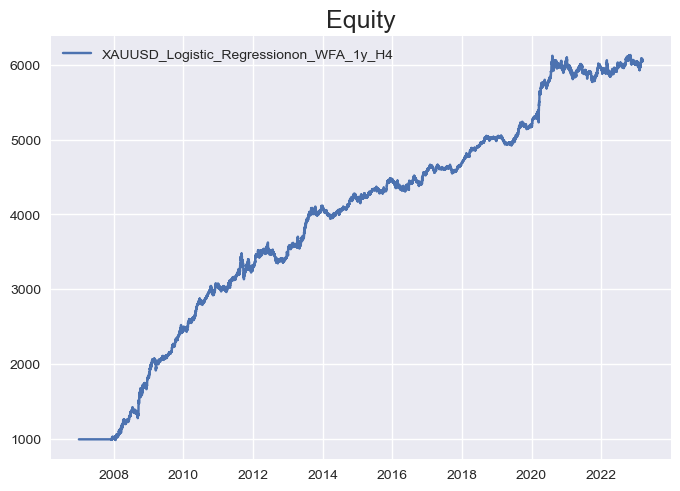

In [134]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [135]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [136]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [137]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [138]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [139]:
test = ml.Run()

In [140]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   88.351496
Equity Final [$]                     4982.284
Equity Peak [$]                      5082.109
Return [%]                           398.2284
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    8.357154
Volatility (Ann.) [%]                8.347789
Sharpe Ratio                         1.001122
Sortino Ratio                        1.623095
Calmar Ratio                         0.480448
Max. Drawdown [%]                  -17.394505
Avg. Drawdown [%]                   -0.646426
Max. Drawdown Duration      727 days 20:00:00
Avg. Drawdown Duration        9 days 15:00:00
# Trades                                 7895
Win Rate [%]                        55.148828
Best Trade [%]                       5.490625
Worst Trade [%]                     -6.215651
Avg. Trade [%]                    

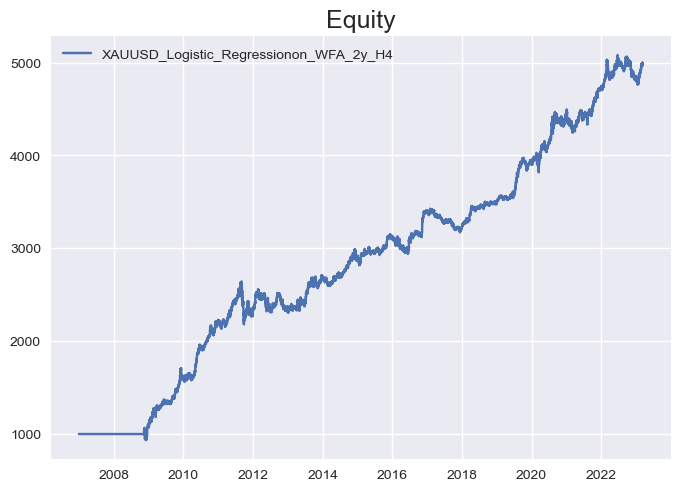

In [141]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [142]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [143]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [144]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [145]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [146]:
test = ml.Run()

In [147]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   82.529169
Equity Final [$]                     3344.799
Equity Peak [$]                      3788.224
Return [%]                           234.4799
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    6.220441
Volatility (Ann.) [%]                9.188765
Sharpe Ratio                         0.676962
Sortino Ratio                        1.051407
Calmar Ratio                         0.301683
Max. Drawdown [%]                    -20.6191
Avg. Drawdown [%]                    -0.94416
Max. Drawdown Duration     1099 days 04:00:00
Avg. Drawdown Duration       15 days 10:00:00
# Trades                                 7148
Win Rate [%]                        54.420817
Best Trade [%]                       5.490625
Worst Trade [%]                     -6.215651
Avg. Trade [%]                    

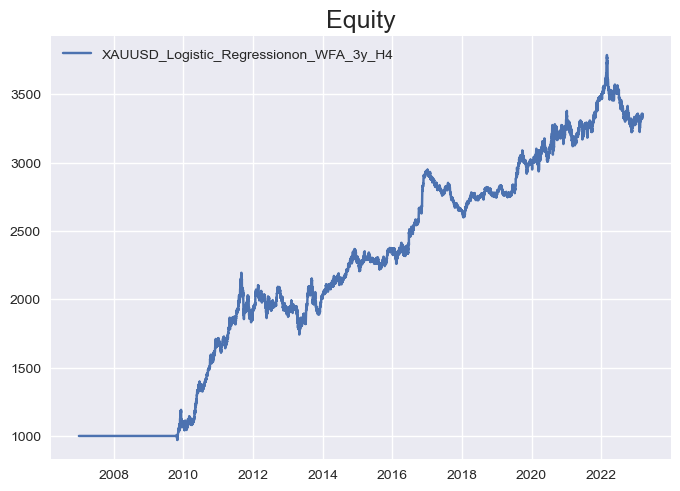

In [148]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [149]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [150]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [151]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [152]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [153]:
test = ml.Run()

In [154]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   76.706843
Equity Final [$]                     2045.753
Equity Peak [$]                      2345.186
Return [%]                           104.5753
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    3.642169
Volatility (Ann.) [%]               13.333005
Sharpe Ratio                         0.273169
Sortino Ratio                        0.401116
Calmar Ratio                         0.089139
Max. Drawdown [%]                   -40.85958
Avg. Drawdown [%]                   -1.923396
Max. Drawdown Duration     3064 days 12:00:00
Avg. Drawdown Duration       35 days 21:00:00
# Trades                                 6281
Win Rate [%]                        54.402165
Best Trade [%]                       5.490625
Worst Trade [%]                     -6.243967
Avg. Trade [%]                    

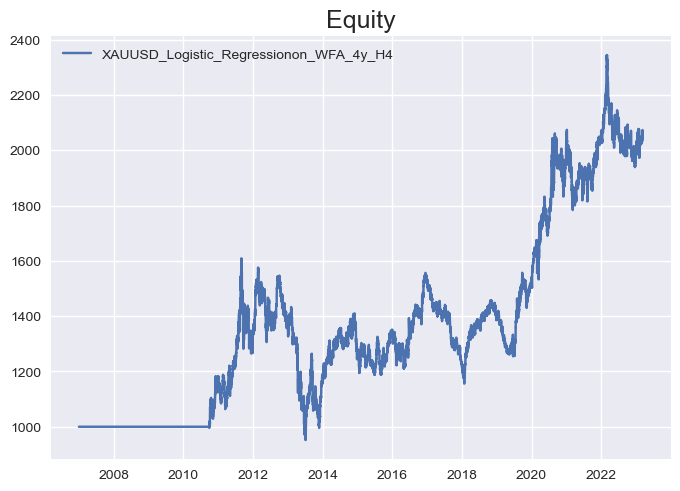

In [155]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [156]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [157]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [158]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [159]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [160]:
test = ml.Run()

In [161]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   11.032385
Equity Final [$]                         4.15
Equity Peak [$]                       578.217
Return [%]                             -99.17
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                  -21.296295
Volatility (Ann.) [%]               33.648071
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.283487
Avg. Drawdown [%]                  -20.339638
Max. Drawdown Duration     3824 days 08:00:00
Avg. Drawdown Duration      382 days 02:00:00
# Trades                                  596
Win Rate [%]                        51.845638
Best Trade [%]                       3.688428
Worst Trade [%]                     -6.243967
Avg. Trade [%]                    

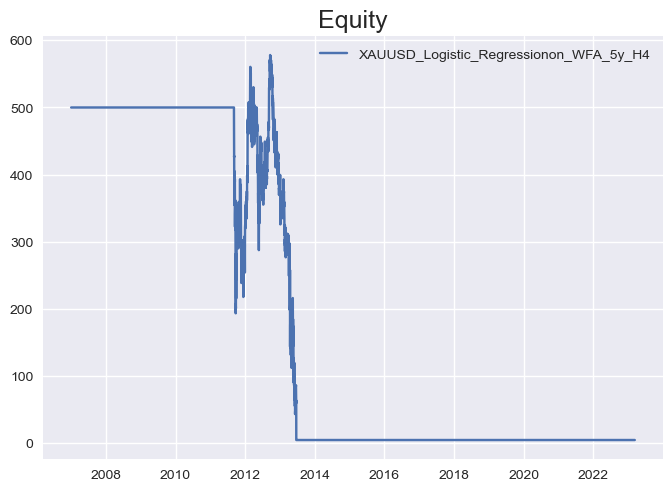

In [162]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [163]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [164]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [165]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [166]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [167]:
test = ml.Run()

In [168]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                    65.06219
Equity Final [$]                      992.467
Equity Peak [$]                      1305.822
Return [%]                            -0.7533
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                   -0.037785
Volatility (Ann.) [%]                22.05322
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -67.935095
Avg. Drawdown [%]                   -5.585939
Max. Drawdown Duration     3442 days 08:00:00
Avg. Drawdown Duration      175 days 03:00:00
# Trades                                 5493
Win Rate [%]                         54.23266
Best Trade [%]                        5.73108
Worst Trade [%]                     -6.243967
Avg. Trade [%]                    

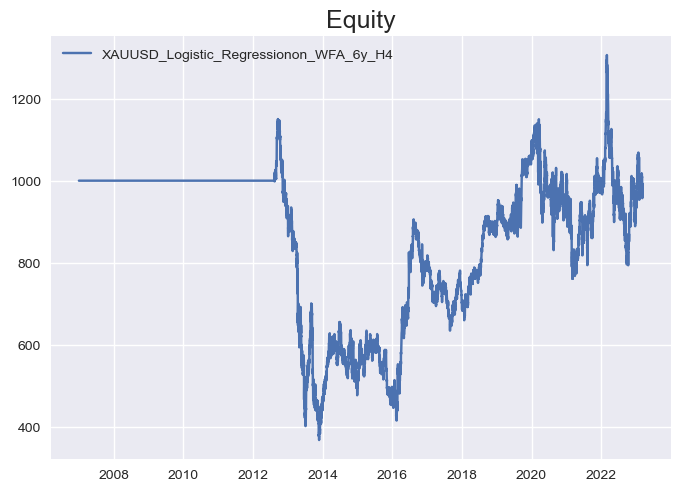

In [169]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [170]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [171]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [172]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [173]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [174]:
test = ml.Run()

In [175]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   59.239863
Equity Final [$]                     1078.219
Equity Peak [$]                      1709.518
Return [%]                             7.8219
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.377113
Volatility (Ann.) [%]               13.068423
Sharpe Ratio                         0.028857
Sortino Ratio                        0.040288
Calmar Ratio                         0.008393
Max. Drawdown [%]                   -44.93442
Avg. Drawdown [%]                   -1.897392
Max. Drawdown Duration     1255 days 20:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                 5465
Win Rate [%]                        54.565416
Best Trade [%]                        5.73108
Worst Trade [%]                     -5.205037
Avg. Trade [%]                    

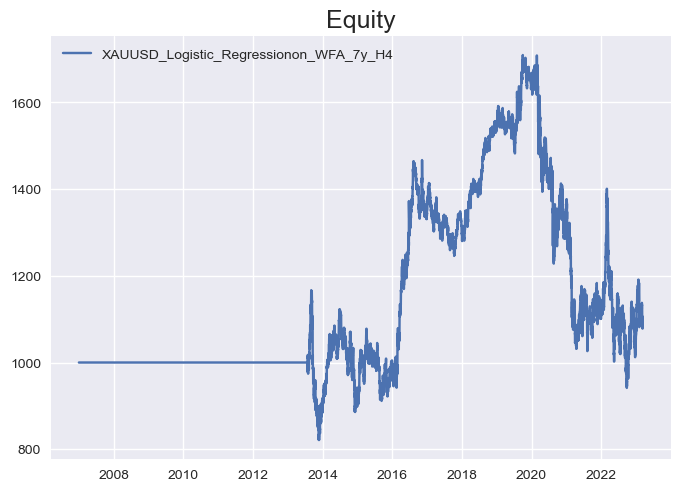

In [176]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [177]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [178]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [179]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [180]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [181]:
test = ml.Run()

In [182]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   53.417536
Equity Final [$]                     1383.415
Equity Peak [$]                      1840.686
Return [%]                            38.3415
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                     1.63536
Volatility (Ann.) [%]               11.979533
Sharpe Ratio                         0.136513
Sortino Ratio                        0.199741
Calmar Ratio                         0.046617
Max. Drawdown [%]                  -35.080834
Avg. Drawdown [%]                   -1.288367
Max. Drawdown Duration     1246 days 08:00:00
Avg. Drawdown Duration       20 days 14:00:00
# Trades                                 5240
Win Rate [%]                        53.912214
Best Trade [%]                        5.73108
Worst Trade [%]                     -4.467755
Avg. Trade [%]                    

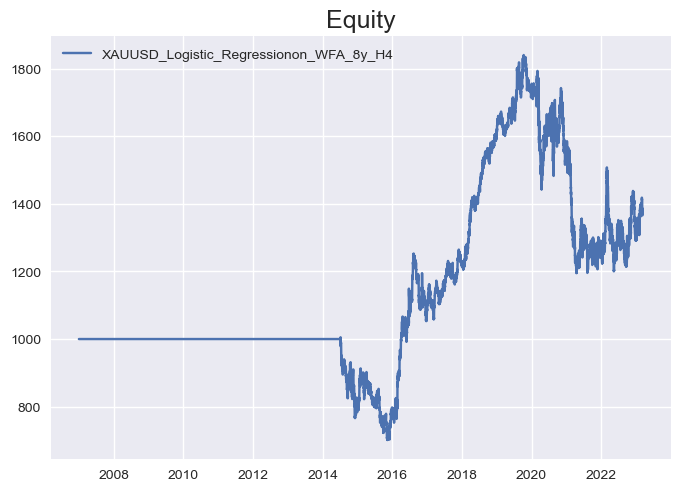

In [183]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [184]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [185]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [13]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H1'

### Window size 1 year

In [187]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [188]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [189]:
test = ml.Run()

In [190]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   93.824211
Equity Final [$]                     4481.844
Equity Peak [$]                      4680.071
Return [%]                           348.1844
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    7.783792
Volatility (Ann.) [%]                9.858876
Sharpe Ratio                         0.789521
Sortino Ratio                        1.266437
Calmar Ratio                         0.390236
Max. Drawdown [%]                  -19.946346
Avg. Drawdown [%]                   -0.541705
Max. Drawdown Duration      503 days 21:00:00
Avg. Drawdown Duration        6 days 18:00:00
# Trades                                28222
Win Rate [%]                        53.316562
Best Trade [%]                       6.254102
Worst Trade [%]                     -7.854516
Avg. Trade [%]                    

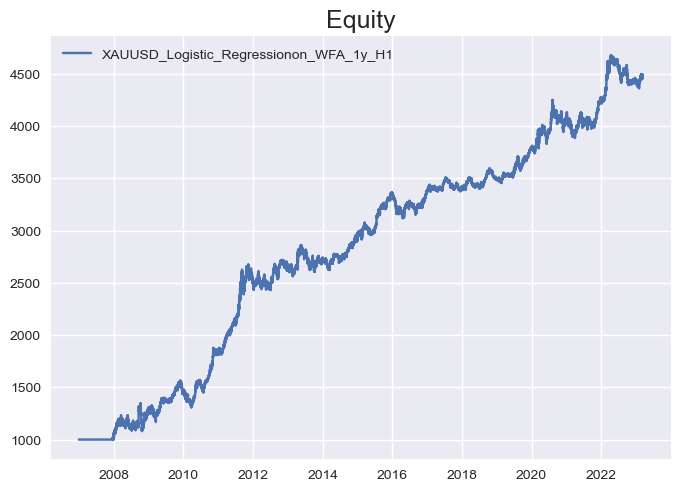

In [191]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [192]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [193]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [194]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [195]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [196]:
test = ml.Run()

In [197]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   87.649443
Equity Final [$]                     3455.661
Equity Peak [$]                      3455.661
Return [%]                           245.5661
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    6.392383
Volatility (Ann.) [%]                 9.56018
Sharpe Ratio                         0.668647
Sortino Ratio                        1.034088
Calmar Ratio                         0.338543
Max. Drawdown [%]                  -18.882055
Avg. Drawdown [%]                   -0.693125
Max. Drawdown Duration     1071 days 08:00:00
Avg. Drawdown Duration        9 days 08:00:00
# Trades                                23023
Win Rate [%]                        53.637667
Best Trade [%]                       4.426038
Worst Trade [%]                     -5.401112
Avg. Trade [%]                    

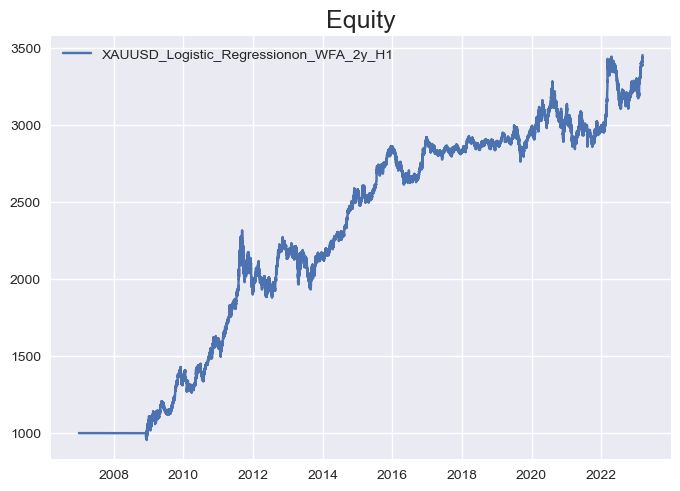

In [198]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [199]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [200]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [14]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [15]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [16]:
test = ml.Run()

In [17]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   81.474675
Equity Final [$]                     2603.657
Equity Peak [$]                       2704.48
Return [%]                           160.3657
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    4.897908
Volatility (Ann.) [%]               11.207171
Sharpe Ratio                         0.437033
Sortino Ratio                        0.652963
Calmar Ratio                         0.191909
Max. Drawdown [%]                  -25.521974
Avg. Drawdown [%]                   -0.895694
Max. Drawdown Duration     1303 days 04:00:00
Avg. Drawdown Duration       13 days 07:00:00
# Trades                                19828
Win Rate [%]                        54.120436
Best Trade [%]                       3.223874
Worst Trade [%]                     -7.328009
Avg. Trade [%]                    

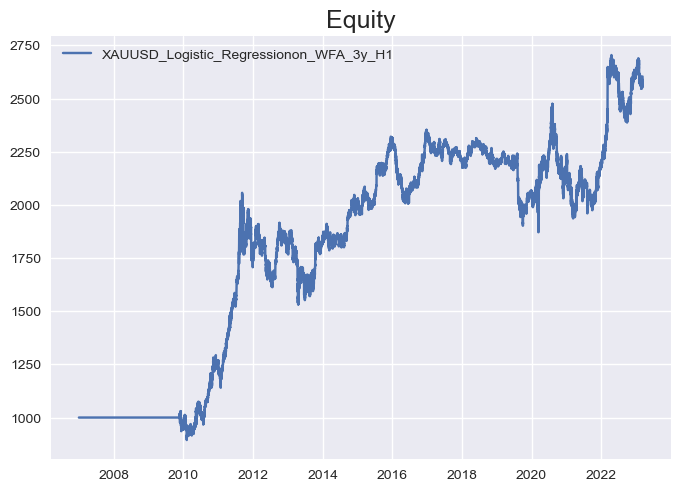

In [18]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [19]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [20]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'M30'

### Window size 1 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')